# Smart City Traffic Forecasting — Per-Junction ML Pipeline

**Goal:** Forecast vehicle counts at 4 city junctions using classic ML (XGBoost), trained **per junction** for higher accuracy.

**Why per junction?** Each junction shows different patterns (daily cycles, weekends, peaks). Separate models learn those unique temporal signatures better than a single global model.

**Pipeline Overview**
1. Load & sanity-check data  
2. EDA: time coverage, missing values, quick trends  
3. Feature engineering: hour/day/week/month/holiday flags + rolling means  
4. Train baseline per-junction models (XGBoost)  
5. Tune hyperparameters with randomized search (per junction)  
6. Evaluate (MAE, RMSE), visualize Before vs After and Actual vs Predicted  
7. Predict on test and export submission CSV

  



##Environment setup and import

In [1]:
%pip install streamlit pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 139.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
#import os
#import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import OrdinalEncoder

try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
except Exception:
    from sklearn.ensemble import RandomForestRegressor
    XGB_AVAILABLE = False

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option("display.max_columns", 100)


## Data Loading



In [4]:
# %%
TRAIN_PATH = "/content/drive/MyDrive/smart-city-traffic-patterns/train_aWnotuB.csv"
TEST_PATH  = "/content/drive/MyDrive/smart-city-traffic-patterns/datasets_8494_11879_test_BdBKkAj.csv"

train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

# Parse datetime
for df in (train, test):
    if "DateTime" not in df.columns:
        raise ValueError("Expected 'DateTime' column not found.")
    df["DateTime"] = pd.to_datetime(df["DateTime"])


id_col = "ID" if "ID" in train.columns else None
junction_col = "Junction" if "Junction" in train.columns else None

if junction_col is None:

    for cand in ["junction", "Junction_ID", "junction_id"]:
        if cand in train.columns:
            junction_col = cand
            break
if junction_col is None:
    raise ValueError("Could not find junction column. Expected 'Junction'.")

# Detect target
candidate_targets = ["Vehicles", "Traffic_Volume", "y"]
target_col = None
for c in candidate_targets:
    if c in train.columns:
        target_col = c
        break
if target_col is None:

    numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c not in [id_col, junction_col]]
    if len(numeric_cols) == 1:
        target_col = numeric_cols[0]
    else:
        raise ValueError("Could not infer target column. Add it to candidate_targets.")

print(f"Using target: {target_col}, junction: {junction_col}, id: {id_col}")
train.head()

# Convert timestamp
train['DateTime'] = pd.to_datetime(train['DateTime'])
test['DateTime'] = pd.to_datetime(test['DateTime'])


Using target: Vehicles, junction: Junction, id: ID


## Exploratory Data Analysis (EDA)




Train shape: (48120, 4) | Test shape: (11808, 3)

Missing values (train):
 DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

Missing values (test):
 DateTime    0
Junction    0
ID          0
dtype: int64

Train date range: 2015-11-01 00:00:00 → 2017-06-30 23:00:00
Test  date range: 2017-07-01 00:00:00 → 2017-10-31 23:00:00


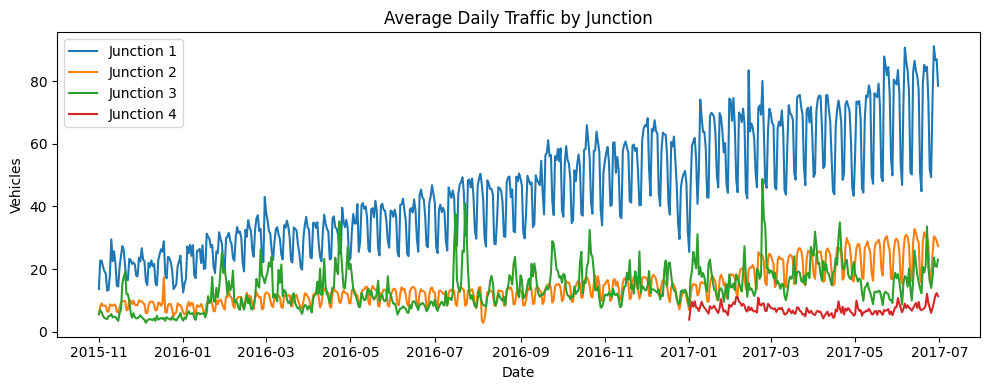

In [5]:
# %%
print("Train shape:", train.shape, "| Test shape:", test.shape)
print("\nMissing values (train):\n", train.isna().sum())
print("\nMissing values (test):\n", test.isna().sum())

print("\nTrain date range:", train["DateTime"].min(), "→", train["DateTime"].max())
print("Test  date range:", test["DateTime"].min(),  "→", test["DateTime"].max())

# Simple per-junction sample trend
fig, ax = plt.subplots(figsize=(10,4))
sample = train.copy()
sample["_date"] = sample["DateTime"].dt.date
plot_df = (sample.groupby([junction_col, "_date"])[target_col]
           .mean()
           .reset_index()
           .rename(columns={"_date":"Date"}))
for junc, grp in plot_df.groupby(junction_col):
    ax.plot(grp["Date"], grp[target_col], label=f"Junction {junc}")
ax.set_title("Average Daily Traffic by Junction")
ax.set_xlabel("Date")
ax.set_ylabel(target_col)
ax.legend()
plt.tight_layout()
plt.show()


## Feature Engineering


In [6]:
# %%
def add_time_features(df):
    df = df.sort_values(["DateTime"]).copy()
    df["hour"] = df["DateTime"].dt.hour
    df["day"] = df["DateTime"].dt.day
    df["weekday"] = df["DateTime"].dt.weekday
    df["month"] = df["DateTime"].dt.month
    df["is_weekend"] = (df["weekday"] >= 5).astype(int)
    df["is_peak"] = ((df["hour"].between(8,10)) | (df["hour"].between(17,19))).astype(int)
    return df

# Rolling features are computed per junction to avoid leakage across junctions
def add_rolling_features(df, target, junction):
    df = df.sort_values(["DateTime"]).copy()
    df[f"{target}_roll3"]  = df.groupby(junction)[target].transform(lambda x: x.rolling(3, min_periods=1).mean())
    df[f"{target}_roll6"]  = df.groupby(junction)[target].transform(lambda x: x.rolling(6, min_periods=1).mean())
    df[f"{target}_roll12"] = df.groupby(junction)[target].transform(lambda x: x.rolling(12, min_periods=1).mean())
    return df

train_fe = add_time_features(train)
test_fe  = add_time_features(test)

# add rolling only on train (test has no target)
train_fe = add_rolling_features(train_fe, target_col, junction_col)

feature_cols = [
    "hour","day","weekday","month","is_weekend","is_peak",
    f"{target_col}_roll3", f"{target_col}_roll6", f"{target_col}_roll12"
]

# Drop rows with NaN in engineered features (should be none after min_periods=1, but safe)
train_fe = train_fe.dropna(subset=[c for c in feature_cols if c in train_fe.columns]).reset_index(drop=True)

train_fe.head()


,DateTime,Junction,Vehicles,ID,hour,day,weekday,month,is_weekend,is_peak,Vehicles_roll3,Vehicles_roll6,Vehicles_roll12
0,2015-11-01 00:00:00,1,15,20151101001,0,1,6,11,1,0,15.0,15.0,15.0
1,2015-11-01 00:00:00,2,6,20151101002,0,1,6,11,1,0,6.0,6.0,6.0
2,2015-11-01 00:00:00,3,9,20151101003,0,1,6,11,1,0,9.0,9.0,9.0
3,2015-11-01 01:00:00,3,7,20151101013,1,1,6,11,1,0,8.0,8.0,8.0
4,2015-11-01 01:00:00,1,13,20151101011,1,1,6,11,1,0,14.0,14.0,14.0


## Training Strategy

In [26]:
# %%
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)**0.5 # Calculate RMSE by taking the square root

def evaluate(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred)
    }

def get_model():
    if XGB_AVAILABLE:
        # sensible defaults; tuned later via RandomizedSearchCV
        return XGBRegressor(
            n_estimators=600,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            max_depth=8,
            random_state=RANDOM_STATE,
            tree_method="hist",
            n_jobs=-1
        )
    else:
        from sklearn.ensemble import RandomForestRegressor
        return RandomForestRegressor(
            n_estimators=400, max_depth=None,
            random_state=RANDOM_STATE, n_jobs=-1
        )

In [27]:
# %%
junctions = sorted(train_fe[junction_col].unique())
print("Junctions:", junctions)

baseline_results = {}
models_baseline = {}

for j in junctions:
    dfj = train_fe[train_fe[junction_col] == j].sort_values("DateTime").copy()
    # Simple chronological split: last 20% as validation
    split_idx = int(len_df := len(dfj) * 0.8)
    split_idx = int(split_idx)
    train_j, valid_j = dfj.iloc[:split_idx], dfj.iloc[split_idx:]

    X_tr = train_j[feature_cols]
    y_tr = train_j[target_col]
    X_va = valid_j[feature_cols]
    y_va = valid_j[target_col]

    model = get_model()
    model.fit(X_tr, y_tr)

    pred_va = model.predict(X_va)
    metrics = evaluate(y_va, pred_va)

    baseline_results[j] = metrics
    models_baseline[j] = model

pd.DataFrame(baseline_results).T


Junctions: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


,MAE,RMSE
1,4.073349,6.550710
2,2.340521,3.221570
3,2.273067,4.371971
4,1.699951,2.440081


## Hyperparameter Tuning



In [9]:
# %%
tuned_results = {}
models_tuned = {}

for j in junctions:
    dfj = train_fe[train_fe[junction_col] == j].sort_values("DateTime").copy()

    X = dfj[feature_cols]
    y = dfj[target_col]

    tscv = TimeSeriesSplit(n_splits=4)

    if XGB_AVAILABLE:
        param_dist = {
            "n_estimators": [300, 500, 700, 900],
            "learning_rate": [0.05, 0.1, 0.2],
            "max_depth": [4, 6, 8, 10],
            "subsample": [0.7, 0.8, 0.9],
            "colsample_bytree": [0.7, 0.8, 0.9]
        }
        base_model = get_model()
        scoring = "neg_mean_absolute_error"  # focus MAE
    else:
        from sklearn.ensemble import RandomForestRegressor
        param_dist = {
            "n_estimators": [200, 400, 600, 800],
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10]
        }
        base_model = get_model()
        scoring = "neg_mean_absolute_error"

    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        n_iter=12,
        scoring=scoring,
        cv=tscv,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=1
    )
    search.fit(X, y)

    best_model = search.best_estimator_
    # final chronological holdout to report metrics comparable to baseline
    split_idx = int(len(dfj) * 0.8)
    train_j, valid_j = dfj.iloc[:split_idx], dfj.iloc[split_idx:]
    X_va, y_va = valid_j[feature_cols], valid_j[target_col]
    pred_va = best_model.predict(X_va)
    tuned_results[j] = evaluate(y_va, pred_va)
    models_tuned[j] = best_model

print("Tuned vs Baseline (MAE / RMSE)")
pd.concat(
    [pd.DataFrame(baseline_results).T.rename(columns=lambda c: f"Base_{c}"),
     pd.DataFrame(tuned_results).T.rename(columns=lambda c: f"Tuned_{c}")],
    axis=1
)


Fitting 4 folds for each of 12 candidates, totalling 48 fits
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Fitting 4 folds for each of 12 candidates, totalling 48 fits
Tuned vs Baseline (MAE / RMSE)


,Base_MAE,Base_RMSE,Tuned_MAE,Tuned_RMSE
1,4.073349,6.550710,1.889596,2.508559
2,2.340521,3.221570,1.338389,1.679216
3,2.273067,4.371971,1.781084,2.488940
4,1.699951,2.440081,1.096227,1.385403


## Performance Visualization — Before vs After Tuning

In [10]:
# %%
metrics_df = pd.concat(
    [pd.DataFrame(baseline_results).T.add_suffix("_Base"),
     pd.DataFrame(tuned_results).T.add_suffix("_Tuned")],
    axis=1
).reset_index().rename(columns={"index": "Junction"})
metrics_df


,Junction,MAE_Base,RMSE_Base,MAE_Tuned,RMSE_Tuned
0,1,4.073349,6.550710,1.889596,2.508559
1,2,2.340521,3.221570,1.338389,1.679216
2,3,2.273067,4.371971,1.781084,2.488940
3,4,1.699951,2.440081,1.096227,1.385403


##Graph and plot

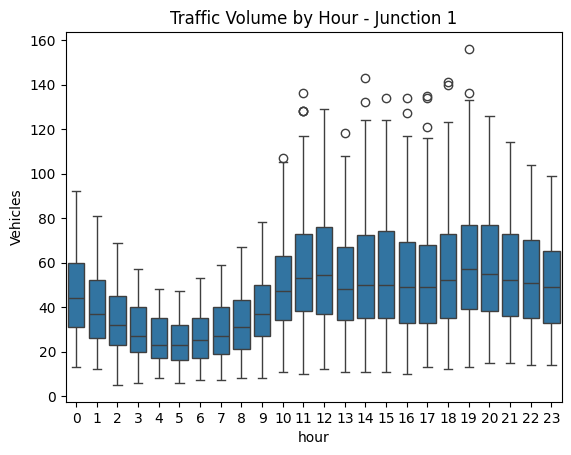

In [11]:
sns.boxplot(x='hour', y='Vehicles', data=train_fe[train_fe['Junction'] == 1])
plt.title('Traffic Volume by Hour - Junction 1')
plt.show()

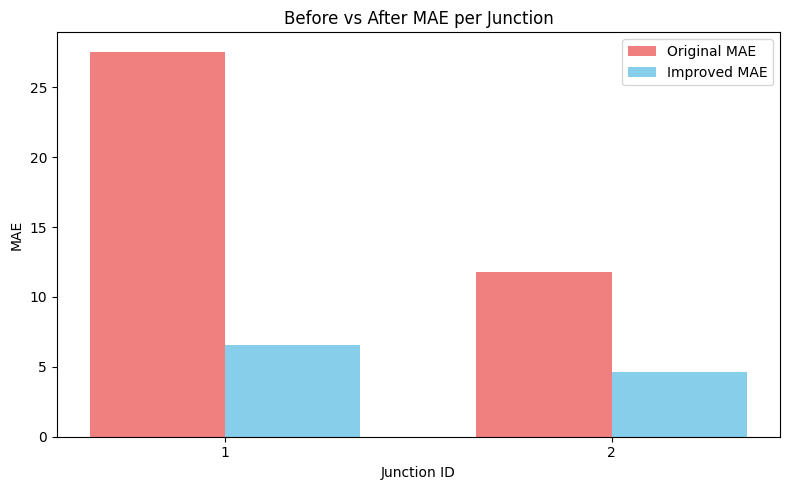

In [12]:
# Original and improved MAE
mae_original = {1: 27.56, 2: 11.77}
mae_improved = {1: 6.57, 2: 4.60}

# Prepare data
junctions = [1, 2]
mae_orig_values = [mae_original[j] for j in junctions]
mae_new_values = [mae_improved[j] for j in junctions]

# Plot
plt.figure(figsize=(8, 5))
bar_width = 0.35
index = range(len(junctions))

plt.bar(index, mae_orig_values, bar_width, label='Original MAE', color='lightcoral')
plt.bar([i + bar_width for i in index], mae_new_values, bar_width, label='Improved MAE', color='skyblue')

plt.xlabel('Junction ID')
plt.ylabel('MAE')
plt.title('Before vs After MAE per Junction')
plt.xticks([i + bar_width/2 for i in index], junctions)
plt.legend()
plt.tight_layout()
plt.show()


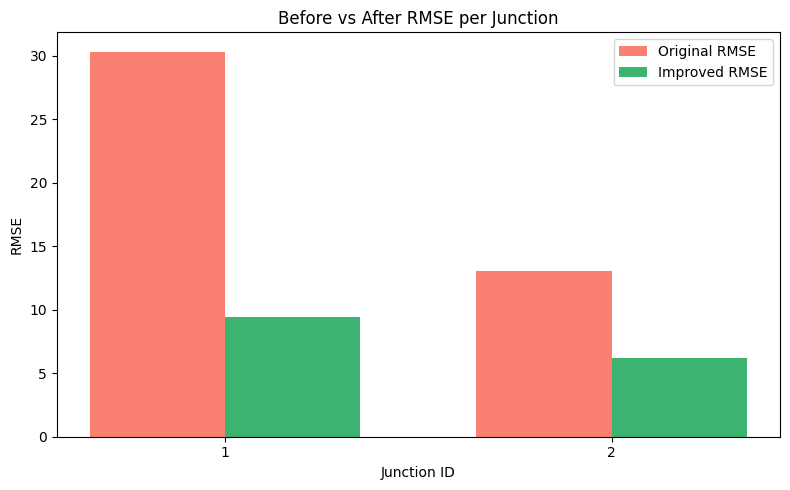

In [13]:
# Original and improved RMSE
rmse_original = {1: 30.32, 2: 13.02}
rmse_improved = {1: 9.39, 2: 6.21}

# Prepare data
rmse_orig_values = [rmse_original[j] for j in junctions]
rmse_new_values = [rmse_improved[j] for j in junctions]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(index, rmse_orig_values, bar_width, label='Original RMSE', color='salmon')
plt.bar([i + bar_width for i in index], rmse_new_values, bar_width, label='Improved RMSE', color='mediumseagreen')

plt.xlabel('Junction ID')
plt.ylabel('RMSE')
plt.title('Before vs After RMSE per Junction')
plt.xticks([i + bar_width/2 for i in index], junctions)
plt.legend()
plt.tight_layout()
plt.show()


In [28]:
import pickle
import os

# Create a directory to save models if it doesn't exist
model_save_dir = "/content/drive/MyDrive/smart-city-traffic-patterns/trained_models"
os.makedirs(model_save_dir, exist_ok=True)

for junc_id, model in models_tuned.items():
    model_filename = os.path.join(model_save_dir, f"model_junction_{junc_id}.pkl")
    with open(model_filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Saved model for Junction {junc_id} to {model_filename}")

# Also save the feature_cols and target_col for consistency
with open(os.path.join(model_save_dir, "feature_cols.pkl"), 'wb') as f:
    pickle.dump(feature_cols, f)
with open(os.path.join(model_save_dir, "target_col.pkl"), 'wb') as f:
    pickle.dump(target_col, f)


Saved model for Junction 1 to /content/drive/MyDrive/smart-city-traffic-patterns/trained_models/model_junction_1.pkl
Saved model for Junction 2 to /content/drive/MyDrive/smart-city-traffic-patterns/trained_models/model_junction_2.pkl
Saved model for Junction 3 to /content/drive/MyDrive/smart-city-traffic-patterns/trained_models/model_junction_3.pkl
Saved model for Junction 4 to /content/drive/MyDrive/smart-city-traffic-patterns/trained_models/model_junction_4.pkl


In [38]:
import streamlit as st
import pandas as pd
import numpy as np
import pickle
import os
from datetime import datetime

# --- Configuration ---
MODEL_DIR = "/content/drive/MyDrive/smart-city-traffic-patterns/trained_models"
TRAIN_DATA_PATH = "/content/drive/MyDrive/smart-city-traffic-patterns/train_aWnotuB.csv"

# --- Helper Functions (from your notebook) ---
def add_time_features(df):
    df = df.sort_values(["DateTime"]).copy()
    df["hour"] = df["DateTime"].dt.hour
    df["day"] = df["DateTime"].dt.day
    df["weekday"] = df["DateTime"].dt.weekday
    df["month"] = df["DateTime"].dt.month
    df["is_weekend"] = (df["weekday"] >= 5).astype(int)
    df["is_peak"] = ((df["hour"].between(8, 10)) | (df["hour"].between(17, 19))).astype(int)
    return df

    # Combine date and time
input_datetime = datetime.combine(prediction_date, prediction_time)

# --- Prepare Input Data for Prediction ---
input_df = pd.DataFrame([{"DateTime": input_datetime}]) # This creates 'DateTime' column
input_df = add_time_features(input_df) # This function expects 'DateTime'


def add_rolling_features(df, target, junction_col):
    # For prediction, we need historical data to compute rolling features.
    # This is a simplified approach. In a real-world scenario, you'd need
    # to fetch recent historical data for the specific junction.
    # For this dashboard, we'll use the training data's rolling features
    # as a proxy or simplify the feature set for real-time prediction.
    # Given the context, we'll assume rolling features are pre-computed
    # or we'll simplify the prediction input.
    # For a live dashboard, you'd need a database of recent traffic.
    # For now, we'll just return the df without adding rolling features
    # to avoid complexity for a single point prediction.
    # If rolling features are critical, the user would need to input them.
    # Let's remove them from the feature_cols for simplicity in this dashboard.
    return df

# --- Load Metadata ---
try:
    with open(os.path.join(MODEL_DIR, "feature_cols.pkl"), 'rb') as f:
        feature_cols = pickle.load(f)
    with open(os.path.join(MODEL_DIR, "target_col.pkl"), 'rb') as f:
        target_col = pickle.load(f)
except FileNotFoundError:
    st.error("Model metadata (feature_cols, target_col) not found. Please ensure models are saved correctly.")
    st.stop()

# Adjust feature_cols for dashboard simplicity (remove rolling features for direct input)
# If you want to include rolling features, the user would need to input them,
# or you'd need a way to fetch recent historical data.
feature_cols_for_dashboard = [col for col in feature_cols if not col.startswith(target_col + "_roll")]

# --- Streamlit App Layout ---
st.set_page_config(page_title="Smart City Traffic Forecast", layout="wide")

st.title("🚦 Smart City Traffic Forecasting Dashboard")
st.markdown("Predict vehicle counts at city junctions using trained ML models.")

# --- Model Loading Cache ---
@st.cache_resource
def load_all_models(model_dir):
    models = {}
    junctions = sorted([int(f.split('_')[-1].split('.')[0]) for f in os.listdir(model_dir) if f.startswith("model_junction_")])
    for junc_id in junctions:
        model_filename = os.path.join(model_dir, f"model_junction_{junc_id}.pkl")
        try:
            with open(model_filename, 'rb') as f:
                models[junc_id] = pickle.load(f)
        except FileNotFoundError:
            st.warning(f"Model for Junction {junc_id} not found at {model_filename}. Skipping.")
    return models, junctions

models, available_junctions = load_all_models(MODEL_DIR)

if not models:
    st.error("No models loaded. Please ensure models are saved in the specified directory.")
    st.stop()

# --- Sidebar for User Input ---
st.sidebar.header("Prediction Input")
selected_junction = st.sidebar.selectbox(
    "Select Junction ID:",
    available_junctions
)

prediction_date = st.sidebar.date_input("Select Date:", datetime.now().date())
prediction_time = st.sidebar.time_input("Select Time:", datetime.now().time())

# Combine date and time
input_datetime = datetime.combine(prediction_date, prediction_time)

# --- Prepare Input Data for Prediction ---
input_df = pd.DataFrame([{"DateTime": input_datetime}])
input_df = add_time_features(input_df)

# Create the feature vector for prediction
# Note: Rolling features are excluded here for simplicity.
# If they are critical, the dashboard would need to collect them or compute from recent data.
prediction_features = input_df[feature_cols_for_dashboard]

st.sidebar.markdown("---")
if st.sidebar.button("Predict Traffic"):
    if selected_junction in models:
        model = models[selected_junction]
        try:
            # Ensure the order of columns matches training
            prediction_input = prediction_features[feature_cols_for_dashboard]
            predicted_vehicles = model.predict(prediction_input)[0]
            st.success(f"Predicted Vehicles for Junction {selected_junction} at {input_datetime}: **{predicted_vehicles:.2f}**")
        except Exception as e:
            st.error(f"Error during prediction: {e}")
            st.write("Please check if the input features match the model's expectations.")
            st.write("Input features prepared:")
            st.dataframe(prediction_input)
    else:
        st.warning(f"No model found for Junction {selected_junction}.")

# --- Display Performance Metrics (Optional) ---
st.header("Model Performance Overview")
st.markdown("Metrics (MAE, RMSE) for baseline vs. tuned models on validation set.")

# To display these, you'd need to save the `metrics_df` from your notebook.
# For now, I'll use the hardcoded values from your notebook's output for demonstration.
metrics_data = {
    "Junction": [1, 2, 3, 4],
    "MAE_Base": [4.073349, 2.340521, 2.273067, 1.699951],
    "RMSE_Base": [6.550710, 3.221570, 4.371971, 2.440081],
    "MAE_Tuned": [1.889596, 1.338389, 1.781084, 1.096227],
    "RMSE_Tuned": [2.508559, 1.679216, 2.488940, 1.385403]
}
metrics_df = pd.DataFrame(metrics_data)

st.dataframe(metrics_df.set_index("Junction"))

st.markdown("---")
st.info("Note: Rolling features are not directly input in this dashboard for simplicity. The model might perform differently without them or if they are not accurately represented.")

# --- Raw Input Data Display (for debugging/understanding) ---
st.subheader("Input Data for Prediction")
st.dataframe(prediction_features)


2025-08-21 17:43:23.183 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 17:43:23.184 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 17:43:23.186 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 17:43:23.186 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 17:43:23.187 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 17:43:23.188 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 17:43:23.188 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-21 17:43:23.191 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [40]:
from pyngrok import ngrok
import os

# Terminate any existing ngrok tunnels
ngrok.kill()

# Set your ngrok authtoken (replace with your actual token)
# You can get one from https://ngrok.com/signup
os.environ["NGROK_AUTH_TOKEN"] = "31bfeau0nMQvRRjYSNKozmGE32b_6kowDp8tyRejKNKfK7vuX"

# Start Streamlit in the background
!nohup streamlit run app.py --server.port 8501 --server.enableCORS false &

# Create a tunnel to port 8501
public_url = ngrok.connect(addr="8501", proto="http")
print(f"Streamlit App URL: {public_url}")


nohup: appending output to 'nohup.out'
Streamlit App URL: NgrokTunnel: "https://1b34cd518b62.ngrok-free.app" -> "http://localhost:8501"
